# Sales prediction using ML


Instead of using an ARIMA family algorithm to perform a predcition, let's just test a small set of ML algorithms and check if they can serve as a base for tha prediction engine in a future production environment.

This idea let us explore if is indeed any advantage in using the sensors installed in the restaurant, and get an approximation on their influence in the actual prediction.


In [2]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid

In [3]:
alt.renderers.enable('notebook')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


First, let's load the orders data in a daily fashion. These data has been already generated by a small ETL in a previous process. That process will be run periodically in the production stage to generate the appropiate data to retrain the model and generate continuous predictions

In [4]:
df = pd.read_csv("../data/daily_orders.csv")

Then extend the dataframe by adding a set of shifted fields after the variable we want to predict. We must get a dataframe with the date, and a set of v(n) fields containing the number of tickets sold (n) days before the row's date (hence, v0 is the number of orders made this day, v1 is the number of orders made the day before and so on)  

In [5]:
df.columns=['date','v0']

input_col = []
for i in range(1,8):
    input_col.append("v"+str(i))
    df["v"+str(i)]=df["v0"].shift(i)

In [6]:
df=df.dropna()
df.tail()

,date,v0,v1,v2,v3,v4,v5,v6,v7
216,2019-04-25,126,122.0,109.0,109.0,0.0,0.0,0.0,0.0
217,2019-04-26,129,126.0,122.0,109.0,109.0,0.0,0.0,0.0
218,2019-04-27,65,129.0,126.0,122.0,109.0,109.0,0.0,0.0
219,2019-04-28,1,65.0,129.0,126.0,122.0,109.0,109.0,0.0
220,2019-04-29,40,1.0,65.0,129.0,126.0,122.0,109.0,109.0


### Separate train and test data.

Unfortunately we do not have too much information, so we have to deal with a small bunch of records. Let's get the last month (or so) for testing and the previous data for training.


In [6]:
df_train = df[df['date']<="2019-03-21"]
df_test = df[df['date']>"2019-03-21"]

In [7]:
X=df_train[input_col]
y=df_train["v0"]
X_test = df_test[input_col]
y_test = df_test["v0"]

First, let's try a RandomForestRegressor.

In [8]:
reg = RandomForestRegressor(max_depth=20)

In [9]:
reg.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Feature importances
Let's check the influence of each feature in the final prediction

In [10]:
reg.feature_importances_

array([0.10493852, 0.03802867, 0.03677065, 0.03204476, 0.0520204 ,
       0.05755365, 0.67864335])

In [11]:
# Build a samll dataframe to plot the feature importance using altair
features = pd.DataFrame(reg.feature_importances_)
features['name']=X_test.columns
features.columns = ['importance','feature']
features.set_index('feature')

,importance
feature,
v1,0.104939
v2,0.038029
v3,0.036771
v4,0.032045
v5,0.052020
v6,0.057554
v7,0.678643


The values in the former table show a clear influence of the sales value of 7 days ago, as we expected from the start.

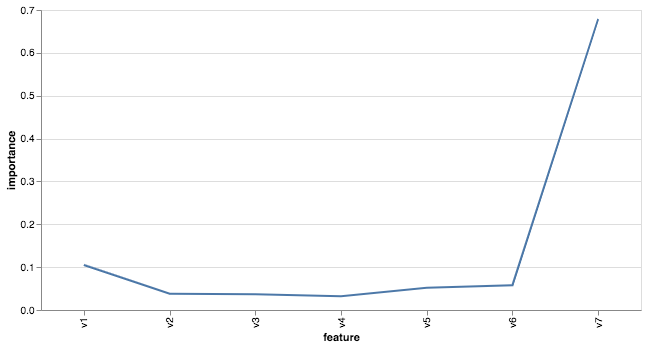

In [12]:
alt.Chart(features).encode(x='feature',y='importance').properties(width=600).mark_line()

Get the MSE for future reference and model selection

In [13]:
mean_squared_error(y_test,reg.predict(X_test))

1232.9069230769232

Let's compare the actual value and the predictions in the testing set by plotting them.

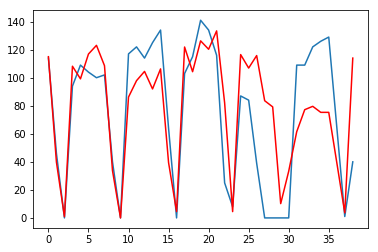

In [14]:
plt.plot(y_test.values)
plt.plot(reg.predict(X_test),color='red')

This is clearly a bad predictor... Let's do a grid selection to find the best parameters, but this time we will use a GBoost regressor.

In [27]:
param_grid=ParameterGrid({"max_depth":[2,3,4,5,6,7,8],"min_samples_leaf":[5,10,20,50,200,300]})

# findBestFit searches for the best set of parameters to build the model
def findBestFit(param_grid, X,y,X_test,y_test):

    best_fit = None

    for param in param_grid:
        reg2 = GradientBoostingRegressor(max_depth=param["max_depth"],min_samples_leaf=param["min_samples_leaf"])
        reg2.fit(X,y)
        error = mean_squared_error(y_test,reg2.predict(X_test))
        
        if best_fit is None or best_fit[1] > error: 
            best_fit=(param, error)
            print("BEST FIT",best_fit)
        
    return best_fit[0]


In [16]:
best_fit = findBestFit(param_grid, X,y,X_test,y_test)

BEST FIT ({'max_depth': 2, 'min_samples_leaf': 5}, 1317.9418432580114)
BEST FIT ({'max_depth': 2, 'min_samples_leaf': 10}, 1248.535972617018)


In [17]:
reg2 = GradientBoostingRegressor(max_depth=best_fit['max_depth'],min_samples_leaf=best_fit['min_samples_leaf'])
reg2.fit(X,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=10,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

Let's plot the results.

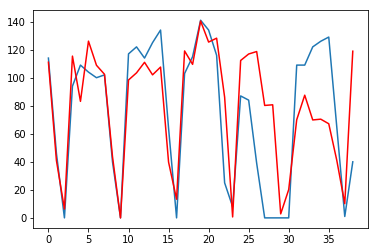

In [18]:
plt.plot(y_test.values)
plt.plot(reg2.predict(X_test),color='red')

This is slightly better and so is the MSE (1248.535 against 1527.783), but not good enough...
Let's also calculate the Pearson's correlation coefficient among the real and predicted data from the testing set.

In [19]:
np.corrcoef(y_test,reg2.predict(X_test))[0][1]

0.7161641998556636

## Adding the pedestrian's traffic data

Well, let's check if the sensors are good to improve the model's output or not. Since we have the number of bystanders in a daily fashion, lets load it, and join this data with the previous dataframe to incorporate a richer set of features into the model


In [20]:
tdf = pd.read_csv("../data/daily_traffic.csv")

In [21]:
tdf.tail()

,date,traffic
162,2019-03-02,6931
163,2019-03-03,4832
164,2019-03-04,6698
165,2019-03-05,7298
166,2019-03-06,6370


In [22]:
mixedDf = pd.merge(df,tdf,how='inner',on='date')

Unfortunately we have less number of records in the traffic set, so we will have to stick to a smaller data range.
Let's build the train and test sets

In [23]:
df_train = mixedDf[mixedDf['date']<="2019-02-02"]
df_test = mixedDf[mixedDf['date']>"2019-02-02"]

In [24]:
X=df_train[input_col + ['traffic']]
y=df_train["v0"]
X_test = df_test[input_col + ['traffic']]
y_test = df_test["v0"]

Here, and for the sake of objectivity, we will repeat the same sequence of operations we did without the traffic data.

In [25]:
reg = RandomForestRegressor(max_depth=20)

In [26]:
reg.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [27]:
reg.feature_importances_

array([0.0337223 , 0.03057333, 0.02901807, 0.0144925 , 0.0366263 ,
       0.08146771, 0.04159304, 0.73250675])

In [28]:
# Build a samll dataframe to plot the feature importance using altair
features = pd.DataFrame(reg.feature_importances_)
features['name']=X_test.columns
features.columns = ['importance','feature']
features.set_index('feature')

,importance
feature,
v1,0.033722
v2,0.030573
v3,0.029018
v4,0.014492
v5,0.036626
v6,0.081468
v7,0.041593
traffic,0.732507


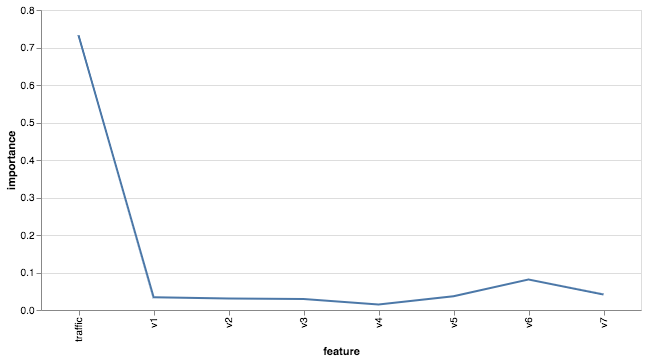

In [29]:
alt.Chart(features).encode(x='feature',y='importance').properties(width=600).mark_line()

Wow! Seems like the traffic is a very important feature to take into account!

In [30]:
mean_squared_error(y_test,reg.predict(X_test))

705.5725

And the actual MSE has improved almost 3 times!!!

Let's compare the actual value and the predictions in the testing set by plotting them.

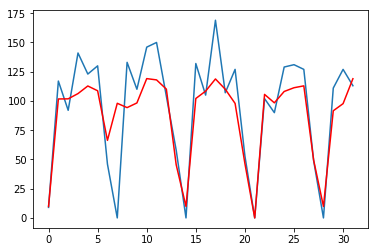

In [31]:
plt.plot(y_test.values)
plt.plot(reg.predict(X_test),color='red')

However, let's do the same grid search.

In [32]:
best_fit = findBestFit(param_grid, X,y,X_test,y_test)

BEST FIT ({'max_depth': 2, 'min_samples_leaf': 5}, 560.3067906651356)


In [33]:
reg2 = GradientBoostingRegressor(max_depth=best_fit['max_depth'],min_samples_leaf=best_fit['min_samples_leaf'])
reg2.fit(X,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=5,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

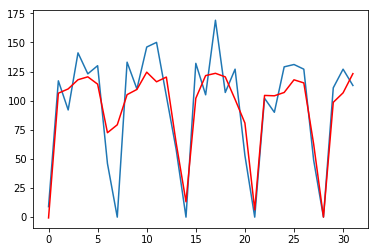

In [34]:
plt.plot(y_test.values)
plt.plot(reg2.predict(X_test),color='red')

From the MSE point o view, we ended up with an almost 3 times better predictor!! (560.410 against 1248 from the model without the traffic info)

In [35]:
np.corrcoef(y_test,reg2.predict(X_test))[0][1]

0.8845479136987614

And the correlation coefficient seems better... but not good enough.

## Adding weather info , holidays and shifted traffic info

Though this doesn't seem bad for a restaurant sales predictor, the last model present a few issues:

1. The model relays on the traffic info of the current day and we cannot have this information until the next day.
2. The model doesn't work well for sundays and holidays, were there the number of orders should be 0 or very different from any labour day.
3. The model doesn't take into account the weather conditions. This is something that the restaurant owner believes is a very important information, since weather can affect the tendency of the bystanders to get into the restaurant and have any drink or food.

So, to solve these issues, we will change the model a bit:

1. We will use shifted traffic info instead of the current one
2. We will add an extra couple of fields containing the day of the week and a boolean indicating if it is in fact a holiday or not.
3. And, last but not least, we will add some weather information. Fortunately we can access the AEMET info and predictions for the next 4 days. We will take into account solar radiation level, temperatures (min, average and max), wind speed, precipitations, and some other values.


In [36]:
holidays = pd.read_csv('../data/holidays.csv')
wdf = pd.read_csv("../data/daily_weather.csv")
tdf = pd.read_csv("../data/daily_traffic.csv")

Let's shift the traffic info

In [37]:
tdf.columns=['date','t0']

for i in range(1,8):
    df["t"+str(i)]=tdf["t0"].shift(i)

In [38]:
mixedDf = pd.merge(df,wdf,how='inner',on='date')
mixedDf = pd.merge(mixedDf,holidays,how='inner',on='date')
mixedDf = pd.merge(mixedDf,tdf,how='inner',on='date')

In [39]:
mixedDf.head()

,date,v0,v1,v2,v3,v4,v5,v6,v7,t1,...,racha,horaracha,sol,presMax,horaPresMax,presMIn,horaPresMin,weekday,holiday,t0
0,2018-09-28,68,101.0,85.0,81.0,78.0,0.0,29.0,75.0,7141.0,...,7.8,Varias,10.9,956.6,00,949.9,18,4,0,7384
1,2018-09-29,27,68.0,101.0,85.0,81.0,78.0,0.0,29.0,7384.0,...,8.9,12:51,10.8,951.8,Varias,947.4,16,5,0,6202
2,2018-09-30,0,27.0,68.0,101.0,85.0,81.0,78.0,0.0,6202.0,...,9.7,15:05,9.9,951.9,Varias,948.4,17,6,1,4711
3,2018-10-01,68,0.0,27.0,68.0,101.0,85.0,81.0,78.0,4711.0,...,12.8,08:08,10.8,955.0,Varias,951.3,16,0,0,6486
4,2018-10-02,53,68.0,0.0,27.0,68.0,101.0,85.0,81.0,6486.0,...,11.7,11:30,10.9,956.3,09,952.8,16,1,0,6801


In [40]:
df_train = mixedDf[mixedDf['date']<="2019-02-14"]
df_test = mixedDf[mixedDf['date']>"2019-02-14"]

In [41]:
X=df_train[input_col + ['t1','t2','t3','t4','t5','t6','t7','velmedia','prec','tmed','tmin','tmax','sol','weekday','holiday']]
y=df_train["v0"]
X_test = df_test[input_col + ['t1','t2','t3','t4','t5','t6','t7','velmedia','prec','tmed','tmin','tmax','sol','weekday','holiday']]
y_test = df_test["v0"]

In [42]:
reg = RandomForestRegressor(max_depth=20)

In [43]:
reg.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [44]:
reg.feature_importances_

array([0.02686159, 0.01318683, 0.00551751, 0.00455181, 0.00749042,
       0.00561518, 0.06482271, 0.00879642, 0.00743207, 0.01132447,
       0.00337691, 0.00518844, 0.04804555, 0.01200165, 0.00446825,
       0.00357096, 0.00886561, 0.00735803, 0.0027932 , 0.01003159,
       0.30919122, 0.42950957])

In [45]:
# Build a samll dataframe to plot the feature importance using altair
features = pd.DataFrame(reg.feature_importances_)
features['name']=X_test.columns
features.columns = ['importance','feature']
features.set_index('feature')

,importance
feature,
v1,0.026862
v2,0.013187
v3,0.005518
v4,0.004552
v5,0.007490
v6,0.005615
v7,0.064823
t1,0.008796
t2,0.007432


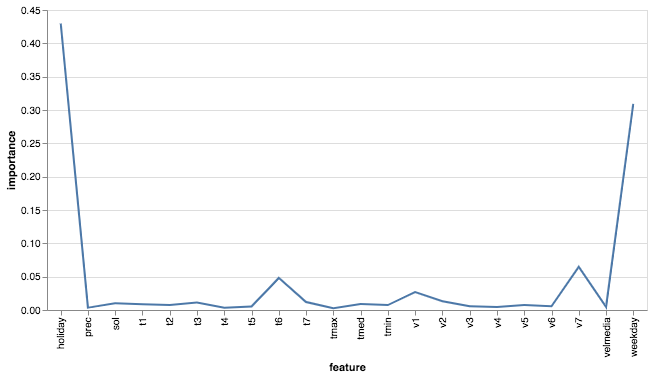

In [46]:
alt.Chart(features).encode(x='feature',y='importance').properties(width=600).mark_line()

It seems that weather conditions are taking a small part in the final predicition individually, but the holidays and the day of the week along with the traffic from 6 days before are rather important.

In [47]:
mean_squared_error(y_test,reg.predict(X_test))

564.1988888888889

Let's compare the actual value and the predictions in the testing set by plotting them.

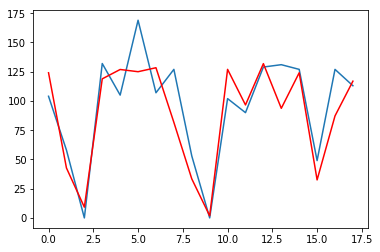

In [48]:
plt.plot(y_test.values)
plt.plot(reg.predict(X_test),color='red')

This seems better. The fact that this model fits better on holidays, looks promising.

Again, let's do the same grid search.

In [49]:
best_fit = findBestFit(param_grid, X,y,X_test,y_test)

BEST FIT ({'max_depth': 2, 'min_samples_leaf': 5}, 400.36647874855237)
BEST FIT ({'max_depth': 2, 'min_samples_leaf': 10}, 361.3607265643757)
BEST FIT ({'max_depth': 2, 'min_samples_leaf': 20}, 329.87453257369225)
BEST FIT ({'max_depth': 3, 'min_samples_leaf': 10}, 314.3623045945884)
BEST FIT ({'max_depth': 8, 'min_samples_leaf': 10}, 299.08097436778456)


In [50]:
reg2 = GradientBoostingRegressor(max_depth=best_fit['max_depth'],min_samples_leaf=best_fit['min_samples_leaf'])
reg2.fit(X,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=8, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=10,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

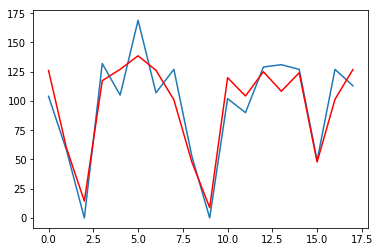

In [51]:
plt.plot(y_test.values)
plt.plot(reg2.predict(X_test),color='red')

From the MSE point o view, we ended up with an almost 4 times better predictor!! (299.080 against 1248 from the model without the traffic info)

In [52]:
np.corrcoef(y_test,reg2.predict(X_test))[0][1]

0.9237556083587625

The correlation coefficient looks very good. So let's consider this model by now, and work new ones when larger data arrives.

## Wrapping all up

Though this is not the most fancy model we could end with, the main purpose of this is to provide a prediction model good enough from the business perspective. In the restaurant sector, the results we have achieved are more than good, and can provide a lot of value to the end user.

However, other techniques have been tested and will be in the near future. The most promising one was a model built with the help of the Prophet library, and some results can be seen in another notebook "Sales prediction with Prophet".

The results of this prediction model (not the Prophet one!) are exported to a json file and used by the front-end app included in this project.

In [53]:
train_forecast = pd.DataFrame(df_train)
train_forecast['v0'] = y
train_forecast['forecast']=reg2.predict(X)


test_forecast = pd.DataFrame(df_test)
test_forecast['v0'] = y_test
test_forecast['forecast'] = reg2.predict(X_test)

forecast = pd.concat([train_forecast,test_forecast])
forecast['orders'] = forecast['v0']

In [54]:
forecast[['date','orders','t1','sol','forecast']].to_json('../data/forecast.json',orient='records')

## Adding social network ratings

In [12]:
holidays = pd.read_csv('../data/holidays.csv')
wdf = pd.read_csv("../data/daily_weather.csv")
tdf = pd.read_csv("../data/daily_traffic.csv")
sdf = pd.read_csv("../data/daily_ratings.csv")

Let's shift the traffic info

In [14]:
tdf.columns=['date','t0']

for i in range(1,8):
    df["t"+str(i)]=tdf["t0"].shift(i)

In [48]:
sdf.columns=['date','r0']

for i in range(1,4):
    sdf["r"+str(i)]=sdf["r0"].shift(i)

In [49]:
mixedDf = pd.merge(df,wdf,how='inner',on='date')
mixedDf = pd.merge(mixedDf,holidays,how='inner',on='date')
mixedDf = pd.merge(mixedDf,tdf,how='inner',on='date')
mixedDf = pd.merge(mixedDf,sdf,how='inner',on='date')

In [51]:
mixedDf.tail()

,date,v0,v1,v2,v3,v4,v5,v6,v7,t1,...,horaPresMax,presMIn,horaPresMin,weekday,holiday,t0,r0,r1,r2,r3
148,2019-02-28,131,129.0,90.0,102.0,0.0,53.0,127.0,107.0,7648.0,...,09,957.5,Varias,3,0,7966,8.858974,8.858974,8.855263,8.855263
149,2019-03-01,127,131.0,129.0,90.0,102.0,0.0,53.0,127.0,7966.0,...,00,953.2,16,4,0,7948,8.875000,8.858974,8.858974,8.855263
150,2019-03-02,49,127.0,131.0,129.0,90.0,102.0,0.0,53.0,7948.0,...,Varias,955.1,17,5,0,6931,8.902439,8.875000,8.858974,8.858974
151,2019-03-05,127,111.0,0.0,49.0,127.0,131.0,129.0,90.0,6698.0,...,Varias,943.8,24,1,0,7298,8.821429,8.902439,8.902439,8.902439
152,2019-03-06,113,127.0,111.0,0.0,49.0,127.0,131.0,129.0,7298.0,...,Varias,935.7,13,2,0,6370,8.848837,8.821429,8.902439,8.902439


In [52]:
df_train = mixedDf[mixedDf['date']<="2019-02-14"]
df_test = mixedDf[mixedDf['date']>"2019-02-14"]

In [18]:
X=df_train[input_col + ['t1','t2','t3','t4','t5','t6','t7','velmedia','prec','tmed','tmin','tmax','sol','weekday','holiday','rating']]
y=df_train["v0"]
X_test = df_test[input_col + ['t1','t2','t3','t4','t5','t6','t7','velmedia','prec','tmed','tmin','tmax','sol','weekday','holiday','rating']]
y_test = df_test["v0"]

In [53]:
X=df_train[input_col + ['t1','t6','sol','weekday','holiday','r0','r1','r2','r3']]
y=df_train["v0"]
X_test = df_test[input_col + ['t1','t6','sol','weekday','holiday','r0','r1','r2','r3']]
y_test = df_test["v0"]

In [54]:
reg = RandomForestRegressor(max_depth=20)

In [55]:
reg.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [56]:
reg.feature_importances_

array([0.02682291, 0.02272589, 0.01452921, 0.0119976 , 0.01064888,
       0.01013949, 0.1212725 , 0.01313374, 0.08304272, 0.01038507,
       0.25156389, 0.39818898, 0.01264497, 0.00432227, 0.00231348,
       0.0062684 ])

In [57]:
# Build a samll dataframe to plot the feature importance using altair
features = pd.DataFrame(reg.feature_importances_)
features['name']=X_test.columns
features.columns = ['importance','feature']
features.set_index('feature')

,importance
feature,
v1,0.026823
v2,0.022726
v3,0.014529
v4,0.011998
v5,0.010649
v6,0.010139
v7,0.121272
t1,0.013134
t6,0.083043


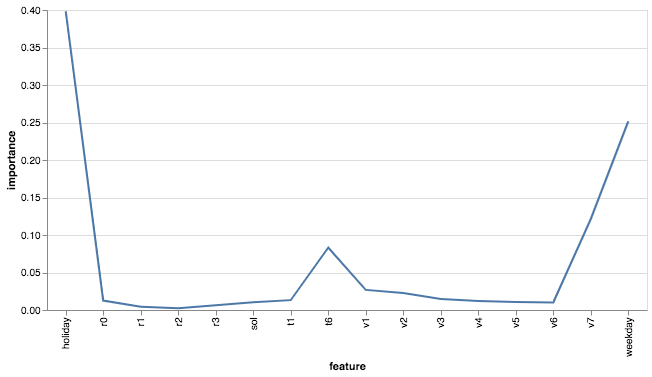

In [58]:
alt.Chart(features).encode(x='feature',y='importance').properties(width=600).mark_line()

It seems that weather conditions are taking a small part in the final predicition individually, but the holidays and the day of the week along with the traffic from 6 days before are rather important.

In [59]:
mean_squared_error(y_test,reg.predict(X_test))

310.76500000000004

Let's compare the actual value and the predictions in the testing set by plotting them.

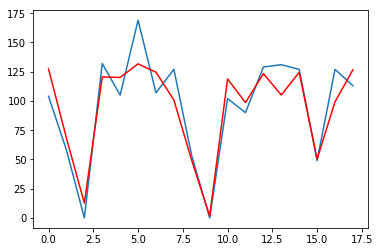

In [60]:
plt.plot(y_test.values)
plt.plot(reg.predict(X_test),color='red')

This seems better. The fact that this model fits better on holidays, looks promising.

Again, let's do the same grid search.

In [63]:
best_fit = findBestFit(param_grid, X,y,X_test,y_test)

BEST FIT ({'max_depth': 2, 'min_samples_leaf': 5}, 417.6681774688411)
BEST FIT ({'max_depth': 2, 'min_samples_leaf': 10}, 339.21501153187205)
BEST FIT ({'max_depth': 6, 'min_samples_leaf': 10}, 328.5394881721979)
BEST FIT ({'max_depth': 7, 'min_samples_leaf': 10}, 300.1947880876919)
BEST FIT ({'max_depth': 8, 'min_samples_leaf': 10}, 294.08057824618004)


In [64]:
reg2 = GradientBoostingRegressor(max_depth=best_fit['max_depth'],min_samples_leaf=best_fit['min_samples_leaf'])
reg2.fit(X,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=8, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=10,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

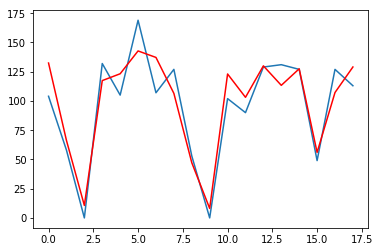

In [65]:
plt.plot(y_test.values)
plt.plot(reg2.predict(X_test),color='red')

From the MSE point o view, we ended up with an almost 4 times better predictor!! (299.080 against 1248 from the model without the traffic info)

In [66]:
np.corrcoef(y_test,reg2.predict(X_test))[0][1]

0.9273661088768056

The correlation coefficient looks very good. So let's consider this model by now, and work new ones when larger data arrives.

## Wrapping all up

Though this is not the most fancy model we could end with, the main purpose of this is to provide a prediction model good enough from the business perspective. In the restaurant sector, the results we have achieved are more than good, and can provide a lot of value to the end user.

However, other techniques have been tested and will be in the near future. The most promising one was a model built with the help of the Prophet library, and some results can be seen in another notebook "Sales prediction with Prophet".

The results of this prediction model (not the Prophet one!) are exported to a json file and used by the front-end app included in this project.

In [32]:
train_forecast = pd.DataFrame(df_train)
train_forecast['v0'] = y
train_forecast['forecast']=reg2.predict(X)


test_forecast = pd.DataFrame(df_test)
test_forecast['v0'] = y_test
test_forecast['forecast'] = reg2.predict(X_test)

forecast = pd.concat([train_forecast,test_forecast])
forecast['orders'] = forecast['v0']

In [33]:
forecast[['date','orders','t1','sol','forecast']].to_json('../data/forecast.json',orient='records')